# Bookmakers performance analysis

In [123]:
import collections
import csv
import numpy as np
import pandas as pd
import sqlite3 as lite

from sklearn.preprocessing import normalize

pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
con = lite.connect('database.sqlite')
df = pd.read_sql_query('select * from match', con)

In [103]:
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [104]:
df.columns[-30:]

Index(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA'],
      dtype='object')

In [105]:
bm_names = set([x[:-1] for x in df.columns[-30:]])

In [106]:
bm_names

{'B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'PS', 'SJ', 'VC', 'WH'}

## Margins calculation

Let $x_i$ denote the odd of result $i$ for a given match and a given bookmaker. In this notebook, we use 0 for AWAY_win, 1 for DRAW and 2 for HOME_win.

The estimated probability of result $i$ by the bookmaker is: $\widehat{p}_i = \dfrac{\frac{1}{x_i}}{\sum \frac{1}{x_j}}$.

Thus, the expected return for the investment of 1€ following the bookmaker's predictions is:
$E = \big( \sum_i (\widehat{p}_i x_i) \widehat{p}_i \big) -1$, which simplifies to $E = \dfrac{1}{\sum \frac{1}{x_j}} - 1$.

The bookmakers allways set $\sum \frac{1}{x_j} > 1$ so that the expected return of the gambler is negative. This quantity is reffered to as 'the bookmaker's margin'.

In [107]:
for bm in bm_names:
    df[bm+'_marg'] = df[bm+'H'].map(lambda x: 1/x) \
                    +df[bm+'D'].map(lambda x: 1/x) \
                    +df[bm+'A'].map(lambda x: 1/x) 

#### True results and bookmakers prediction calculations

In [108]:
df['result'] = (df['home_team_goal'] - df['away_team_goal']).map(lambda x: 1 + np.sign(x))

In [109]:
df['result'].head()

0    1
1    1
2    0
3    2
4    0
Name: result, dtype: int64

In [110]:
def odd2res(odd):
    if odd in ['A', 'D', 'H']:
        return 0 * (odd == 'A') + 1 * (odd == 'D') + 2 * (odd == 'H')
    else:
        return np.nan

In [111]:
for bm in bm_names:
    df[bm+'_pred'] = df[[bm+'H', bm+'D', bm+'A']].idxmin(1).map(lambda x: str(x)[-1]).map(odd2res)

### 1. Average margin VS average accuracy

In [112]:
dum = df[[bm+'_marg' for bm in bm_names]].mean(axis=0)
mean_marg = {bm: dum[bm+'_marg'] for bm in bm_names}

In [113]:
mean_marg

{'B365': 1.0615304906781624,
 'BS': 1.0832829044271475,
 'BW': 1.0804561149080494,
 'GB': 1.0834303081614045,
 'IW': 1.0992039309426902,
 'LB': 1.0868106330486311,
 'PS': 1.0237958640665705,
 'SJ': 1.0690922697244931,
 'VC': 1.0526852000381517,
 'WH': 1.0801907397475856}

In [114]:
mean_acc = {}
for bm in bm_names:
    idx = df[bm+'_pred'].loc[~np.isnan(df[bm+'_pred'].values)].index
    mean_acc[bm] = (df[bm+'_pred'].loc[idx] == df['result'].loc[idx]).mean(axis=0)

In [115]:
mean_acc

{'B365': 0.53328611898016998,
 'BS': 0.53223642398135729,
 'BW': 0.53151716500553714,
 'GB': 0.53276373393588472,
 'IW': 0.5316607460035524,
 'LB': 0.53143287816988827,
 'PS': 0.52713108882521487,
 'SJ': 0.53342691700298295,
 'VC': 0.53287841191066998,
 'WH': 0.53147844579327452}

### 2. Correlation between BM's confidence and margin

There seem to be no obvious correlation between the bookmakers' margins and the confidence they have in their predictions.

In [116]:
for bm in bm_names:
    df[bm+'_pmax'] = df[[bm+'H', bm+'D', bm+'A']].min(1).map(lambda x: 1/x) / df[bm+'_marg']

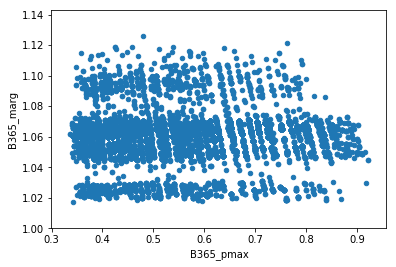

In [117]:
df.plot.scatter(x='B365'+'_pmax', y='B365'+'_marg')

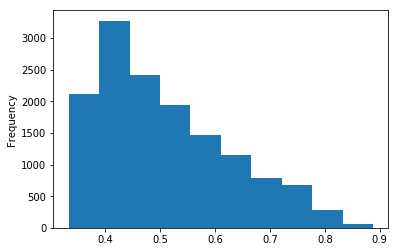

In [133]:
df[bm+'_pmax'].plot.hist()

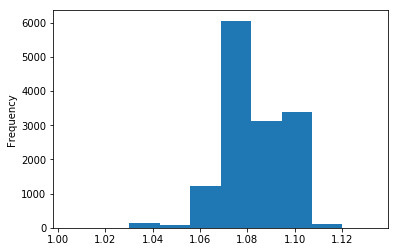

In [134]:
df[bm+'_marg'].plot.hist()

### 3. Accuracy on first and second half of each season

Bookmakers all make better predictions during the second half of the season.

In [88]:
half_season_acc = {}
for bm in bm_names:
    half_season_acc[bm] = {}
    
    idx = df[bm+'_pred'].loc[~np.isnan(df[bm+'_pred'].values)].index
    fst = df[df['stage'] < 20].index
    sec = df[df['stage'] > 19].index
    
    fst_idx = list(set(idx) & set(fst))
    sec_idx = list(set(idx) & set(sec))
    
    half_season_acc[bm]['first'] = (df[bm+'_pred'].loc[fst_idx] == df['result'].loc[fst_idx]).mean(axis=0)
    half_season_acc[bm]['second'] = (df[bm+'_pred'].loc[sec_idx] == df['result'].loc[sec_idx]).mean(axis=0)

In [89]:
half_season_acc

{'B365': {'first': 0.53096168232067165, 'second': 0.53593409714989115},
 'BS': {'first': 0.53003300330032999, 'second': 0.53477072578196172},
 'BW': {'first': 0.53017456359102244, 'second': 0.53304883831199623},
 'GB': {'first': 0.52997095326115662, 'second': 0.53597449908925321},
 'IW': {'first': 0.52997920997921, 'second': 0.53358742258218195},
 'LB': {'first': 0.52913752913752909, 'second': 0.53404779969650984},
 'PS': {'first': 0.52303797468354429, 'second': 0.53175662788479883},
 'SJ': {'first': 0.53168103448275861, 'second': 0.53549955225789947},
 'VC': {'first': 0.53055624844100768, 'second': 0.53552793852575653},
 'WH': {'first': 0.52949496630335302, 'second': 0.53373768006065203}}

### 4. Average margin and average accuracy by league.

In [143]:
marg_by_league = df[['league_id']+[bm+'_marg' for bm in bm_names]].groupby('league_id').mean()
marg_by_league

,VC_marg,PS_marg,BS_marg,BW_marg,WH_marg,IW_marg,SJ_marg,LB_marg,B365_marg,GB_marg
league_id,,,,,,,,,,
1,1.072551,1.028334,1.103663,1.092610,1.098675,1.118976,1.075624,1.107387,1.070194,1.098361
1729,1.038593,1.020230,1.068110,1.072162,1.065787,1.089126,1.057733,1.065300,1.042276,1.073649
4769,1.050367,1.024847,1.084059,1.073585,1.074690,1.089643,1.069219,1.094429,1.062049,1.081278
7809,1.049246,1.020226,1.077406,1.072647,1.075139,1.089124,1.066497,1.078729,1.061570,1.074397
10257,1.049979,1.020451,1.079644,1.073533,1.075160,1.089754,1.067822,1.083048,1.062015,1.076113
13274,1.063820,1.028734,1.089813,1.094756,1.097437,1.121370,1.077388,1.105302,1.069247,1.096513
15722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17642,1.062174,1.028521,1.100935,1.087521,1.095793,1.113282,1.081068,1.105803,1.069044,1.093887
19694,1.054989,1.028749,1.078744,1.101308,1.079877,1.113487,1.082111,1.071686,1.064840,1.096356


In [140]:
marg_by_league.mean(axis=1)

league_id
1        1.086637
1729     1.059297
4769     1.070417
7809     1.066498
10257    1.067752
13274    1.084438
15722         NaN
17642    1.083803
19694    1.077215
21518    1.065933
24558         NaN
dtype: float64

In [141]:
acc_by_league = {}
for league in df['league_id'].unique():
    acc = 0.
    for bm in bm_names:
        idx = df[bm+'_pred'].loc[~np.isnan(df[bm+'_pred'].values)].index
        idx = set(idx) & set(df[df['league_id']==league].index)
        
        acc += (df[bm+'_pred'].loc[idx] == df['result'].loc[idx]).mean(axis=0)
    
    acc_by_league[league] = acc / len(bm_names)

acc_by_league

{1: 0.52634608463465105,
 1729: 0.53285690372399441,
 4769: 0.50603319847832118,
 7809: 0.51204660542218239,
 10257: 0.53623937503526131,
 13274: 0.55393270258256488,
 15722: nan,
 17642: 0.54684117359451445,
 19694: 0.50112555510463075,
 21518: 0.56138605548986864,
 24558: nan}

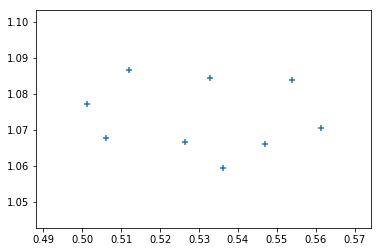

In [152]:
plt.scatter([v for k,v in acc_by_league.items() if not np.isnan(v)], 
            [v for v in marg_by_league.mean(axis=1).values if not np.isnan(v)],
            marker = '+')

### 4.2 Latest trends by league

In [154]:
latest = df[df['season']=='2015/2016']

In [155]:
marg_by_league = latest[['league_id']+[bm+'_marg' for bm in bm_names]].groupby('league_id').mean()
marg_by_league

,VC_marg,PS_marg,BS_marg,BW_marg,WH_marg,IW_marg,SJ_marg,LB_marg,B365_marg,GB_marg
league_id,,,,,,,,,,
1,1.055869,1.026168,NaN,1.069454,1.089728,1.080849,NaN,1.067632,1.065063,NaN
1729,1.025329,1.020280,NaN,1.060845,1.060589,1.080313,NaN,1.051161,1.027653,NaN
4769,1.033502,1.024609,NaN,1.062299,1.060490,1.080340,NaN,1.069620,1.051501,NaN
7809,1.037612,1.020189,NaN,1.063206,1.061802,1.080532,NaN,1.063592,1.051288,NaN
10257,1.037254,1.020322,NaN,1.059815,1.060833,1.080260,NaN,1.065708,1.051259,NaN
13274,1.047838,1.025826,NaN,1.080135,1.089285,1.102934,NaN,1.066199,1.065237,NaN
15722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17642,1.047067,1.025674,NaN,1.079053,1.089046,1.100329,NaN,1.067597,1.064330,NaN
19694,1.040152,1.026027,NaN,1.099745,1.062667,1.100997,NaN,1.064450,1.064248,NaN


In [156]:
marg_by_league.mean(axis=1)

league_id
1        1.064966
1729     1.046596
4769     1.054623
7809     1.054032
10257    1.053636
13274    1.068208
15722         NaN
17642    1.067585
19694    1.065469
21518    1.052393
24558         NaN
dtype: float64

In [160]:
acc_by_league = {}
for league in latest['league_id'].unique():
    acc = 0.
    for bm in set(bm_names) - set(['BS', 'SJ', 'GB']):
        idx = latest[bm+'_pred'].loc[~np.isnan(latest[bm+'_pred'].values)].index
        idx = set(idx) & set(latest[latest['league_id']==league].index)
        
        acc += (latest[bm+'_pred'].loc[idx] == latest['result'].loc[idx]).mean(axis=0)
    
    acc_by_league[league] = acc / (len(bm_names) - 3)

acc_by_league

{1: 0.51697798366208403,
 1729: 0.47386275715674414,
 4769: 0.4921003035292717,
 7809: 0.5266106442577031,
 10257: 0.53403594738825955,
 13274: 0.55098513521025327,
 15722: nan,
 17642: 0.55025791737460017,
 19694: 0.46731505726446454,
 21518: 0.54644593012875198,
 24558: nan}

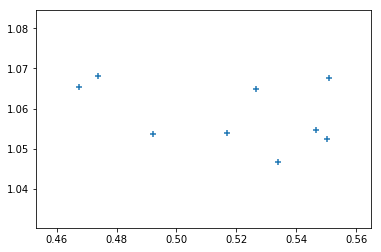

In [161]:
plt.scatter([v for k,v in acc_by_league.items() if not np.isnan(v)], 
            [v for v in marg_by_league.mean(axis=1).values if not np.isnan(v)],
            marker = '+')